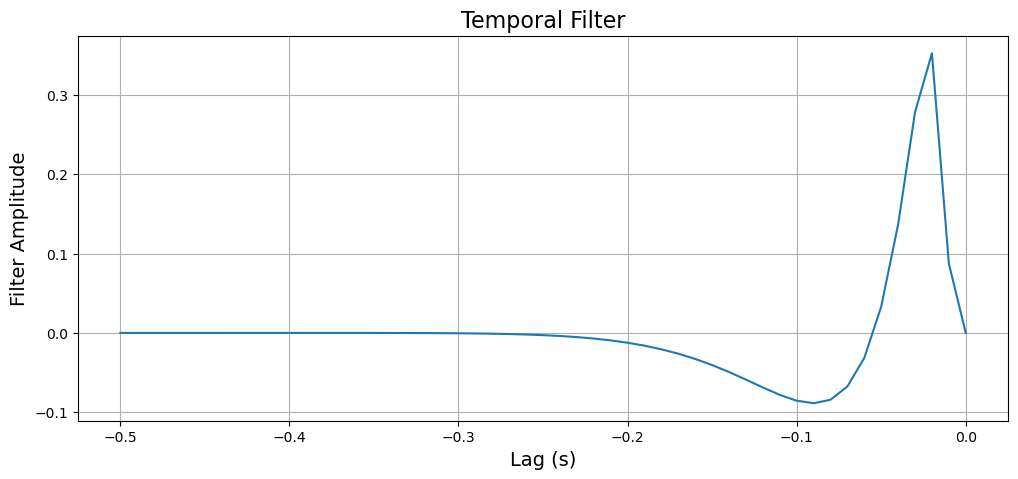

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

filter_bin_width_ms = 10
filter_length_ms = 500
num_filter_bins = int(filter_length_ms/filter_bin_width_ms + 1)

# Define the temporal filter function.
def temporalFun(t, p):
  return p[0] * (((t/p[1])**p[5])/(1+((t/p[1])**p[5]))) * np.exp(-((t/p[2]))) * np.cos(((2*np.pi*t)/p[3])+(2*np.pi*p[4]/360))

# Define temporal parameters.
tparams = [2.699101600403141, 0.017693386617024, 0.037119750110715, 0.586510918255136, 56.559161047519765, 4.001435007252049]


fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,5)

# Filter time base needs to be in seconds for these params.
t = np.linspace(0,filter_length_ms/1000,num_filter_bins)
tfilter = temporalFun(t, tparams)
plt.plot(-t, tfilter)
ax.set_title('Temporal Filter', fontsize=16)
ax.set_xlabel('Lag (s)', fontsize=14)
ax.set_ylabel('Filter Amplitude', fontsize=14)
ax.grid()
plt.show()



(60000,)


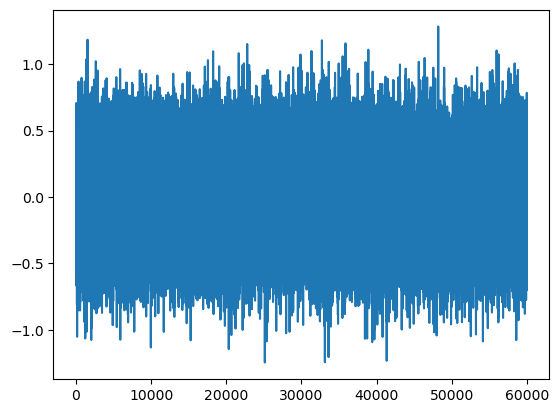

In [2]:
# Create a Gaussian stimulus.
sd = 0.3 # Standard deviation of the Gaussian stimulus.
bin_width_ms = 10 # Bin width in milliseconds.
duration_ms = 1000 * 60 * 10 # Duration of the stimulus in milliseconds.
n_noise_bins = np.ceil(duration_ms / bin_width_ms).astype(int) # Number of time bins.
s = sd * np.random.normal(0, 1, n_noise_bins)
# s = np.zeros(duration_ms)
# for i in range(n_noise_bins):
#   s[i*bin_width_ms:(i+1)*bin_width_ms] = s_tmp[i]

# s = np.kron(s_tmp, np.ones(bin_width_ms))
# fig, ax = plt.subplots(1,1)
print(s.shape)

plt.plot(s)

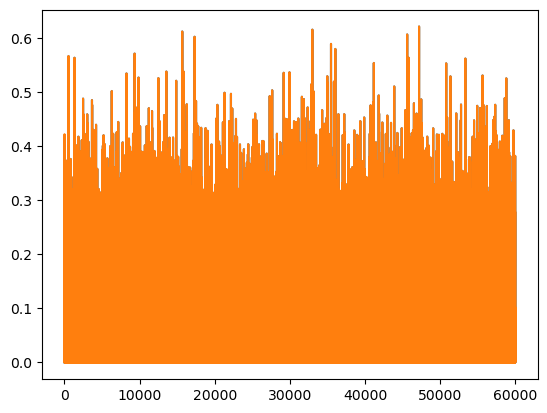

In [3]:
# Define a nonlinearity function.
def relu(x):
  return np.maximum(0.0, x)

def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

# Create the design matrix.
n = len(s)
filter_pts = len(tfilter)

S = np.zeros((n, filter_pts))
S[filter_pts-1:,:] = toeplitz(s[filter_pts-1:], s[:filter_pts][::-1])

# Convolve the stimulus with the filter.
r = np.dot(S, tfilter) #try with np.matmul

# In the Fourier domain, convolution is multiplication.
t_fft = np.arange(len(s))/1000.0*bin_width_ms #np.linspace(0,filter_length_ms/1000,num_filter_bins)
r_fft = np.real( np.fft.ifft( np.fft.fft(s) * np.fft.fft(temporalFun(t_fft, tparams)) ) )

# Pass through the ReLU nonlinearity.
r = relu(r)
r_fft = relu(r_fft)

plt.plot(r)
plt.plot(r_fft)

True


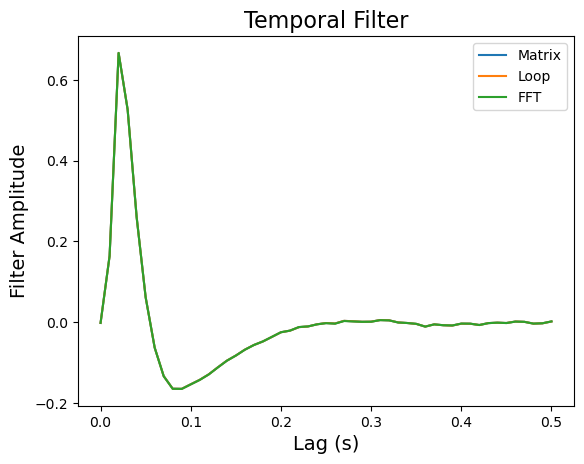

In [4]:
# Compute the reverse-correlation between the stimulus and the response.

# Now, let's do the same operation in a loop.
sta_loop = np.zeros(filter_pts)
for i in range(filter_pts):
  sta_loop[i] = np.dot(S[:,i], r)

# Use matrix multiplication to compute the reverse correlation.
sta_matrix = np.dot(S.T, r)


# Check that the two methods give the same result.
print(np.allclose(sta_matrix, sta_loop))

# Now, let's do the same operation in the Fourier domain.
sta_fft = np.real( np.fft.ifft(np.fft.fft(r_fft) * np.conj( np.fft.fft(s) )) )
sta_fft = sta_fft[:filter_pts] # Just take the first filter_pts values.

# Let's normalize the STA.
sta_matrix = sta_matrix / np.linalg.norm(sta_matrix)
sta_loop = sta_loop / np.linalg.norm(sta_loop)
sta_fft = sta_fft / np.linalg.norm(sta_fft)

fig, ax = plt.subplots(1,1)
ax.plot(t, sta_matrix, label='Matrix')
ax.plot(t, sta_loop, label='Loop')
ax.plot(t, sta_fft, label='FFT')
ax.set_title('Temporal Filter', fontsize=16)
ax.set_xlabel('Lag (s)', fontsize=14)
ax.set_ylabel('Filter Amplitude', fontsize=14)
ax.legend()